#  **Comparison between manual annotations from different annotators**
## Created by Pau Márquez, UPC, 2021

### **Description**
This notebooks analyses the manual annotation performed on the AI4Agriculture 2020 database. This database has been annotated (bboxes defining the grapes in the images) by eight different people. A subset of the images (xx images) has been processed by all except one of the annotators. This allows to compare the different styles of annotations. Whith this analysis, the quality of the labels from the different annotators it can be determined.

### **Running this notebook**
This notebook can be run:

1. from google Colaboratory 
1. locally. 

When running locally, use a virtualenv according to [requirements.txt](requirements.txt). Configure and run the next four code cells according to the option selected (Colab or local).

### **Notebook & environment setup**

In [ ]:
# Run this cell only if you intend to work with the data stored in Google Drive
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# Run this cell only if you intend to work with the data stored in Google Drive
!pip install xmltodict
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [3]:
# If you want to work with the data in Google Drive (not on the Calcula servers), create (or link to) a folder 
# containing the manual labels and the database images 

AGGREGATED_DATA_PATH='/content/drive/MyDrive/Recerca/Projectes/AI4EU/data/2020_data_collection/aggregated_labels/'
IMAGE_DATA_PATH='/content/drive/MyDrive/Recerca/Projectes/AI4EU/data/2020_data_collection/complete_dataset/'
ANNOT_IOU_PATH='/content/drive/MyDrive/Recerca/Projectes/AI4EU/data/2020_data_collection/cache_files/annotators_iou.json'
PRED_DATA_PATH='/content/drive/MyDrive/Recerca/Projectes/AI4EU/grape_detection/pau/faster_inference_ai4agriculture.json'

# If working on the server, these folders should exist on your working directory:
#AGGREGATED_DATA_PATH='../data/aggregated_labels/'
#IMAGE_DATA_PATH='../data/complete_dataset/'
#ANNOT_IOU_PATH=''
#PRED_DATA_PATH=''

In [ ]:
# Run this cell only if you intend to work with the data stored in Google Drive
!git clone https://github.com/imatge-upc/AI4Agriculture-grape-detection.git
#!git clone https://github.com/paumarquez/AI4Agriculture-grape-detection.git
%cd AI4Agriculture-grape-detection

### **Import libraries**

In [133]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import os
from skimage import io
#import mmcv
#import xmltodict
import seaborn as sns
import json
from scipy.stats import hmean
from PIL import ImageFile

In [134]:
from src.utils.visualization_utils import display_image_w_bbox
from src.utils.file_utils import get_image_info # Added, JRMR, slightly different
from src.utils.mask_bbox_utils import add_mask, get_mask_metrics, bbox_IoU

### **Definitions and useful functions**

In [21]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
IOU_THRESHOLD = 0.7

In [67]:
def get_all_mask_metrics(image_ids):
    mask_metrics=[]
    for i, image_id in enumerate(image_ids):
        if not i % 10:
            print(f'left {len(image_ids) - i} images')
        bboxes = get_image_info(image_id, os.path.join(AGGREGATED_DATA_PATH, f'{image_id}_aggregated.xml'))
        annotators = bboxes["annotator"].unique()
        for ann in annotators:
            bb_ann = bboxes[bboxes["annotator"] == ann][['xmin', 'ymin', 'xmax', 'ymax']]
            for ann2 in annotators:
                if ann2 < ann:
                    bb_ann2 = bboxes[bboxes["annotator"] == ann2][['xmin', 'ymin', 'xmax', 'ymax']]
                    recall, precision, f1 = get_mask_metrics(bb_ann.values, bb_ann2.values)
                    mask_metrics.append((image_id, ann, ann2, recall, precision, f1))
                    mask_metrics.append((image_id, ann2, ann, precision, recall, f1))
    return pd.DataFrame(mask_metrics, columns=['image_id', 'ann_pred', 'ann_gt', 'recall', 'precision', 'f1'])

In [68]:
def get_iou_annotator(image_ids):
    all_iou=[]
    for i, image_id in enumerate(image_ids):
        if not i % 10:
            print(f'left {len(image_ids) - i} images')
        bboxes = get_image_info(image_id, os.path.join(AGGREGATED_DATA_PATH, f'{image_id}_aggregated.xml'))
        for ann in bboxes["annotator"].unique():
            bb_an = bboxes[bboxes["annotator"] == ann][['xmin', 'ymin', 'xmax', 'ymax']]
            mask_metrics.append((image_id, ann, bb_an, *get_mask_metrics(bb_an, bboxes)))
            for i, bbox in enumerate(bb_an.values):
                for _, bbox_2 in bboxes.iterrows():
                    all_iou.append((
                        image_id,
                        ann,
                        bbox_2['annotator'],
                        i,
                        *bbox_IoU(
                            bbox,
                            bbox_2[['xmin', 'ymin', 'xmax', 'ymax']],
                            return_area_a=True
                        )
                    ))
    return all_iou

In [42]:
image_ids = list(set([file.split('_')[0] for file in os.listdir(AGGREGATED_DATA_PATH) if file != 'classes.txt']))

In [44]:
if os.path.isfile(ANNOT_IOU_PATH):
    with open(ANNOT_IOU_PATH, 'r') as fd:
        all_iou = json.load(fd)
else:
    all_iou = get_iou_annotator(image_ids)
    with open(ANNOT_IOU_PATH, 'w') as fd:
        json_serializable_all_iou = [(str(iou[0]), int(iou[1]), int(iou[2]), int(iou[3]), float(iou[4]), int(iou[5])) for iou in all_iou]
        json.dump(json_serializable_all_iou, fd)
        del json_serializable_all_iou

In [45]:
d_iou = pd.DataFrame(all_iou, columns=["filename", "annotator_1", "annotator_2", "bbox_1_id", "iou", "area_1"])
d_iou = d_iou[d_iou['iou'] != 0]

In [46]:
image_ids[2]

'1598000594057'

In [47]:
d_iou.head()

,filename,annotator_1,annotator_2,bbox_1_id,iou,area_1
0,1597921124508,2,2,0,1.000000,13916
14,1597921124508,2,4,0,0.734654,13916
28,1597921124508,2,2,1,1.000000,5880
42,1597921124508,2,4,1,0.566445,5880
56,1597921124508,2,2,2,1.000000,20601


In [48]:
intersection_boxes = d_iou[
    ["filename", "annotator_1", "bbox_1_id"]
].drop_duplicates().groupby("filename")["annotator_1"].apply(lambda x: len(x.unique()))
all_intersected_filenames = intersection_boxes[intersection_boxes == 7].index

In [77]:
positive_prop_anns  = [0]*8
positive_count_anns = [0]*8
for image_id in all_intersected_filenames.values:
    box_info, shape = get_image_info(image_id, os.path.join(AGGREGATED_DATA_PATH, f'{image_id}_aggregated.xml'),get_shape=True)
    for ann in box_info["annotator"].unique():
        boxes = box_info[ann==box_info["annotator"]].drop("annotator",axis=1).values
        mask  = np.zeros(tuple(map(int,shape))[:-1])
        mask  = add_mask(mask, boxes)
        positive_prop             = mask.sum()/mask.size
        positive_prop_anns[ann]  += positive_prop
        positive_count_anns[ann] += 1
total_pos_size_prop = np.array(positive_prop_anns) / np.array(positive_count_anns)
total_pos_size_prop

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


array([0.02505444, 0.00953642, 0.01843129,        nan, 0.02538169,
       0.02490145, 0.03216213, 0.03117065])

In [78]:
boxes = d_iou[["filename", "annotator_1", "bbox_1_id"]].drop_duplicates()
boxes_intersection = boxes[
    boxes.filename.isin(all_intersected_filenames)
]
mean_box_count = boxes_intersection.groupby(["filename", "annotator_1"]).size().to_frame().reset_index().groupby("annotator_1").mean().apply(lambda x: round(x,1))
boxes = d_iou[["filename", "annotator_1", "bbox_1_id", "area_1"]].drop_duplicates()
annotator_area = boxes[boxes.filename.isin(all_intersected_filenames)].groupby(
    ["filename", "annotator_1"]
)["area_1"].sum().groupby('annotator_1').mean().astype(int)

annotator_basic_stats = pd.concat([mean_box_count, annotator_area],axis=1).rename({"area_1": "Mean positive area per image", 0: "Mean number of boxes"}, axis = 1)
annotator_basic_stats["Mean area per box"] = (annotator_basic_stats.iloc[:,1]/ annotator_basic_stats.iloc[:,0]).astype(np.int)
annotator_basic_stats["Mean percentage of positive area per image"] = np.round(np.delete(total_pos_size_prop,3) * 100,2)
annotator_basic_stats = annotator_basic_stats.drop("Mean positive area per image", axis=1)
annotator_basic_stats

,Mean number of boxes,Mean area per box,Mean percentage of positive area per image
annotator_1,,,
0,18.1,17728,2.51
1,20.2,6023,0.95
2,18.3,13139,1.84
4,25.6,13353,2.54
5,19.9,16051,2.49
6,24.0,18093,3.22
7,24.1,17567,3.12


In [85]:
m_metrics = get_all_mask_metrics(image_ids)

left 52 images
left 42 images
left 32 images
left 22 images
left 12 images
left 2 images


In [86]:
mask_metrics = pd.pivot_table(
    m_metrics.groupby(['ann_pred','ann_gt'])[["f1", "recall"]].mean(),
    index=['ann_pred'],
    columns=["ann_gt"]
).rename({'recall': 'Mask Recall', 'f1': 'Mask F-score'}, axis=1)

In [87]:
mask_metrics[["Mask Recall"]].fillna(1).apply(lambda x: round(x,2))

Mask Recall                                    
ann_gt             0     1     2     4     5     6     7
ann_pred                                                
0               1.00  0.99  0.86  0.85  0.83  0.72  0.72
1               0.36  1.00  0.45  0.36  0.36  0.28  0.29
2               0.64  0.90  1.00  0.62  0.63  0.51  0.52
4               0.87  0.99  0.85  1.00  0.83  0.74  0.75
5               0.83  0.98  0.85  0.82  1.00  0.70  0.71
6               0.95  1.00  0.91  0.96  0.93  1.00  0.89
7               0.92  0.99  0.88  0.94  0.90  0.85  1.00

In [88]:
mask_metrics[["Mask F-score"]].fillna(1).apply(lambda x: round(x,2))

Mask F-score                                    
ann_gt              0     1     2     4     5     6     7
ann_pred                                                 
0                1.00  0.52  0.73  0.85  0.83  0.81  0.80
1                0.52  1.00  0.59  0.52  0.52  0.43  0.44
2                0.73  0.59  1.00  0.71  0.72  0.64  0.64
4                0.85  0.52  0.71  1.00  0.83  0.83  0.84
5                0.83  0.52  0.72  0.83  1.00  0.79  0.79
6                0.81  0.43  0.64  0.83  0.79  1.00  0.86
7                0.80  0.44  0.64  0.84  0.79  0.86  1.00

In [89]:
overlap_bbox = pd.pivot_table(
    d_iou.groupby(
        ['filename','annotator_1', 'annotator_2', 'bbox_1_id']
    )['iou'].apply(lambda x: int(any(x > 0.7))).groupby(
        ['annotator_1', 'annotator_2']
    ).mean().to_frame().reset_index().rename({
        'iou': 'Recall (iou threshold=0.7)',
        'annotator_1': 'annotator_gt',
        'annotator_2': 'annotator_pred',
    },axis=1),
    index=['annotator_pred'], columns=["annotator_gt"]
)
overlap_bbox.apply(lambda x: round(x,2))

Recall (iou threshold=0.7)                                    
annotator_gt                            0     1     2     4     5     6     7
annotator_pred                                                               
0                                    1.00  0.02  0.28  0.44  0.42  0.47  0.37
1                                    0.06  1.00  0.10  0.06  0.06  0.05  0.06
2                                    0.30  0.04  1.00  0.21  0.23  0.18  0.15
4                                    0.54  0.02  0.25  1.00  0.38  0.46  0.46
5                                    0.48  0.01  0.25  0.35  1.00  0.40  0.34
6                                    0.49  0.00  0.18  0.40  0.38  1.00  0.48
7                                    0.40  0.01  0.17  0.40  0.33  0.48  1.00

In [90]:
f1_matrix = overlap_bbox.copy()
for i in range(overlap_bbox.shape[0]):
    for j in range(overlap_bbox.shape[1]):
        f1_matrix.values[i][j] = hmean([overlap_bbox.values[i][j], overlap_bbox.values[j][i]])
f1_matrix = f1_matrix.rename({'Recall (iou threshold=0.7)': f'F1-score (threshold={IOU_THRESHOLD})'},axis=1)

In [91]:
f1_matrix.apply(lambda x: round(x,2))

F1-score (threshold=0.7)                                    
annotator_gt                          0     1     2     4     5     6     7
annotator_pred                                                             
0                                  1.00  0.03  0.29  0.48  0.45  0.48  0.38
1                                  0.03  1.00  0.06  0.02  0.02  0.01  0.01
2                                  0.29  0.06  1.00  0.23  0.24  0.18  0.16
4                                  0.48  0.02  0.23  1.00  0.36  0.43  0.43
5                                  0.45  0.02  0.24  0.36  1.00  0.39  0.34
6                                  0.48  0.01  0.18  0.43  0.39  1.00  0.48
7                                  0.38  0.01  0.16  0.43  0.34  0.48  1.00

In [92]:
annotators_mapped_iou = d_iou.copy()
annotators = [0,4,5,6]
annotators_mapped_iou = annotators_mapped_iou[
    annotators_mapped_iou['annotator_1'].isin(annotators) & annotators_mapped_iou['annotator_2'].isin(annotators) 
    & (annotators_mapped_iou['annotator_1'] != annotators_mapped_iou['annotator_2'])
]
copy = annotators_mapped_iou.copy()
annotators_mapped_iou["annotator_2"] = ','.join(map(str,annotators))
copy["annotator_1"] = ','.join(map(str,annotators))
annotators_mapped_iou = pd.concat([
    annotators_mapped_iou,
    copy
])
overlap_bbox_ann = pd.pivot_table(
    annotators_mapped_iou.groupby(
        ['filename','annotator_1', 'annotator_2', 'bbox_1_id']
    )['iou'].apply(lambda x: int(any(x > 0.7))).groupby(
        ['annotator_1', 'annotator_2']
    ).mean().to_frame().reset_index().rename({
        'iou': 'Precision(iou threshold=0.7)',
        'annotator_1': 'annotator_gt',
        'annotator_2': 'annotator_pred',
    },axis=1),
    index=['annotator_gt'], columns=["annotator_pred"]
)

Bounding box metrics (not mask metrics) for the set of annotators {0,4,5,6}: For each annotator, compare with the rest of annotations.

In [93]:
precision = overlap_bbox_ann.iloc[:-1,-1]
recall = overlap_bbox_ann.iloc[-1,:-1]

f1_score = [hmean([p, r]) for p, r in zip(precision.values, recall.values)]
pd.DataFrame({"precision": precision.values, "recall": recall.values, "f1": f1_score}, index = precision.index)

,precision,recall,f1
annotator_gt,,,
0,0.738306,0.676523,0.706066
4,0.560953,0.724806,0.632439
5,0.577982,0.620311,0.598399
6,0.632951,0.667254,0.649650


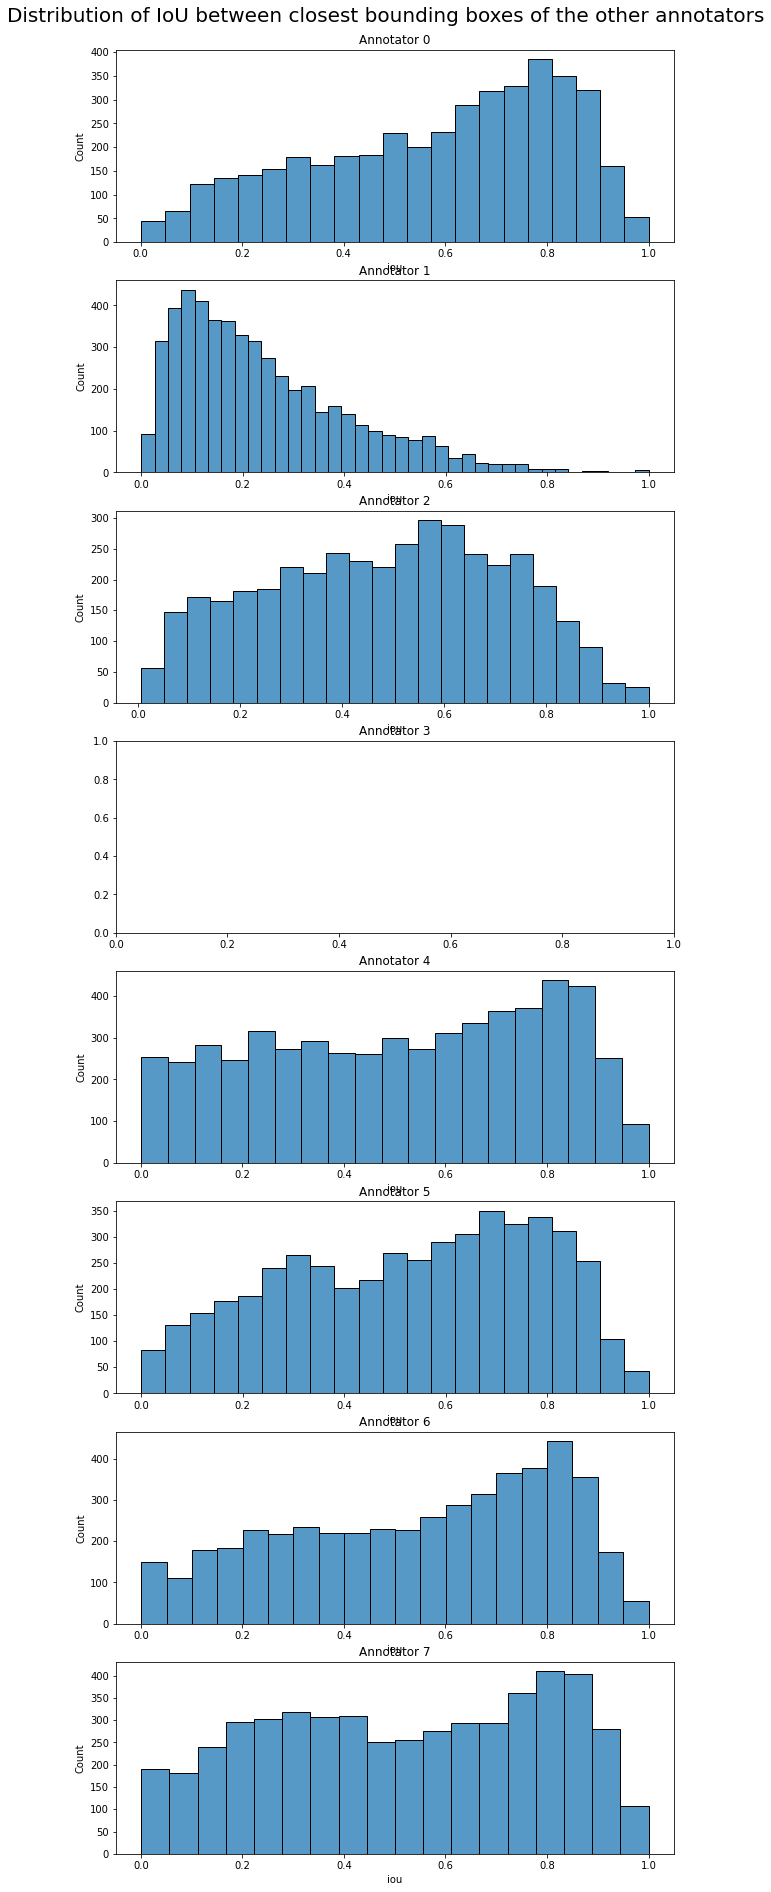

In [94]:
fig, ax = plt.subplots(8, figsize=(10,30))
plt.suptitle('Distribution of IoU between closest bounding boxes of the other annotators',fontsize=20)
x = np.arange(0,1,0.05)
for ann in range(8):
    ax[ann].set_title(f'Annotator {ann}')
    d = d_iou[(d_iou.annotator_1 == ann) & (d_iou.annotator_2 != ann)].groupby(['filename','bbox_1_id', 'annotator_2']).max()
    sns.histplot(d[(d.annotator_1 == ann)].iou, ax=ax[ann])
fig.subplots_adjust(top=0.96)
plt.show()

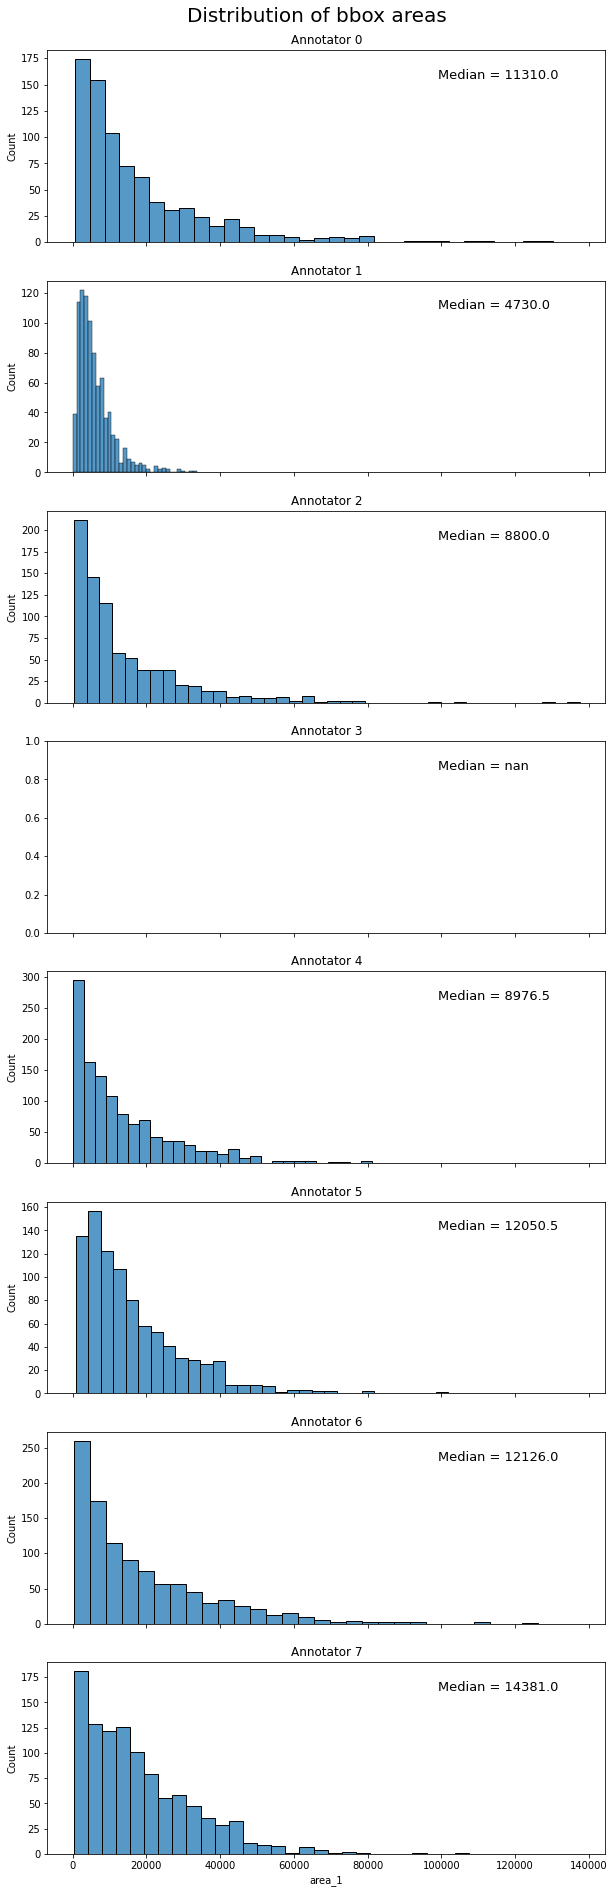

In [96]:
fig, ax = plt.subplots(8, figsize=(10,30), sharex = True)
plt.suptitle('Distribution of bbox areas',fontsize=20)
x = np.arange(0,1,0.05)
for ann in range(8):
    ax[ann].set_title(f'Annotator {ann}')
    areas_bbox = d_iou[(d_iou.annotator_1 == ann) & (d_iou.annotator_2 != ann)].groupby(['filename','bbox_1_id', 'annotator_1'])['area_1'].mean()
    sns.histplot(areas_bbox, ax=ax[ann])
    ax[ann].annotate(f"Median = {round(areas_bbox.median(),2)}", xy=(0.6,0.85), xytext=(0.7, 0.85), textcoords='axes fraction',fontsize=13)
#for ax_i in ax:
#    ax_i.sharex(ax[0])
fig.subplots_adjust(top=0.96)
plt.show()

Some annotators overlap bounding boxes within the same image. In general, this is an issue when training the object detection model.

Annotator 7 has much more overlap.

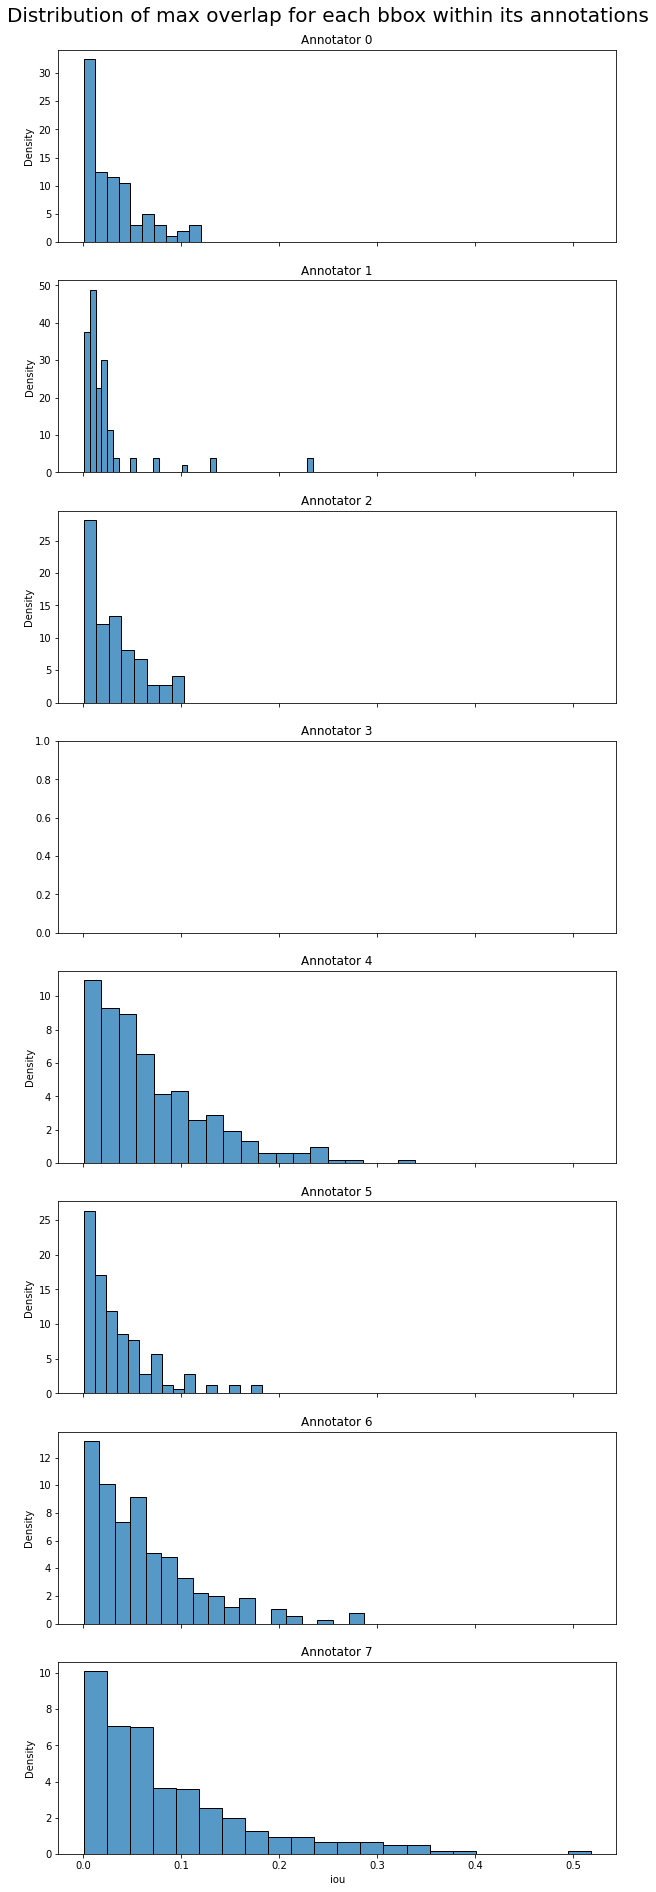

In [97]:
fig, ax = plt.subplots(8, figsize=(10,30), sharex = True)
plt.suptitle('Distribution of max overlap for each bbox within its annotations',fontsize=20)
x = np.arange(0,1,0.05)
for ann in range(8):
    ax[ann].set_title(f'Annotator {ann}')
    overlap_bbox = d_iou[(d_iou.annotator_1 == ann) & (d_iou.annotator_2 == ann) & (d_iou.iou < 0.95) & (d_iou.iou > -0.01)].groupby(['filename','bbox_1_id', 'annotator_1'])['iou'].max()
    sns.histplot(overlap_bbox, ax=ax[ann], stat='density')
#for ax_i in ax:
#    ax_i.sharex(ax[-1])
fig.subplots_adjust(top=0.96)
plt.show()

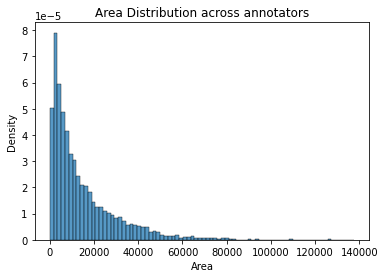

In [98]:
areas_bbox = d_iou[(d_iou.annotator_1 == d_iou.annotator_2)].groupby(['filename','bbox_1_id', 'annotator_1'])['area_1'].mean()
sns.histplot(areas_bbox, stat='density', bins=80)
plt.title('Area Distribution across annotators')
plt.xlabel('Area')
plt.show()

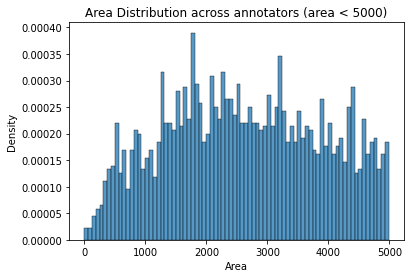

In [99]:
areas_bbox = d_iou[(d_iou.annotator_1 == d_iou.annotator_2)].groupby(['filename','bbox_1_id', 'annotator_1'])['area_1'].mean()
sns.histplot(areas_bbox[areas_bbox < 5000], stat='density', bins=80)
plt.title('Area Distribution across annotators (area < 5000)')
plt.xlabel('Area')
plt.show()

In [100]:
colors_annotators = ['blue','red','pink','brown','purple','grey', 'white', 'yellow']

In [101]:
list(enumerate(colors_annotators))

[(0, 'blue'),
 (1, 'red'),
 (2, 'pink'),
 (3, 'brown'),
 (4, 'purple'),
 (5, 'grey'),
 (6, 'white'),
 (7, 'yellow')]

Some pictures with its annotations and the annotator's corresponding color.

In [135]:
for image_id in image_ids[1:2]:
    print(image_id)

    ima    = io.imread(os.path.join(IMAGE_DATA_PATH, f'{image_id}.jpg'))
    bboxes = get_image_info(image_id, os.path.join(AGGREGATED_DATA_PATH, f'{image_id}_aggregated.xml'))
    display_image_w_bbox(ima, bboxes, colors_annotators=colors_annotators)

Output hidden; open in https://colab.research.google.com to view.

In [137]:
for image_id in image_ids[:2]:

    ima    = io.imread(os.path.join(IMAGE_DATA_PATH, f'{image_id}.jpg'))
    bboxes = get_image_info(image_id, os.path.join(AGGREGATED_DATA_PATH, f'{image_id}_aggregated.xml'))

    display_image_w_bbox(ima, bboxes, annotators=[0,2,7])

Output hidden; open in https://colab.research.google.com to view.